# PHYS20762
# Project 3 - Monte Carlo Techniques Neutron Transport and Scattering Through a Shielding Layer

Lukas Wystemp

University of Manchester  
April 2024

# Introduction

This project aims to develop a computational simulation to study the absorption and scattering processes of thermal neutrons as they pass through shielding materials using Monte Carlo simulations in Python. The materials of interest include water, lead, and graphite. By modeling the behavior of thermal neutrons incident on a shielding layer, we seek to understand and quantify the reflection, absorption, and transmission rates, and how these rates depend on the thickness and composition of the shielding material.

1) First, we will confirm the ability to generate uniformly distributed random numbers using `numpy.random.uniform()`. We will then generate a 3D array of random points and visualise them using a scatter plot, demonstrating spectral issues using the random number generator randssp.ipynb developed by IBM. Next, we will create a random number generator for samples distributed according to an exponential function. 

2) We will write a function to produce isotropic unit vectors and confirm their uniform distribution over a sphere using a scatter plot. We will also develop a function to generate isotropic steps with lengths distributed exponentially and include representative plots. This is needed for the process of simulating neutrons. 

4) Next, we will utilise what we learned in 1-3) to 
visualise the random walk of neutrons through a material slab, considering absorption, scattering, and escape conditions. We will then determine the absorption, reflection, and transmission rates for neutrons passing through a slab of fixed thickness by simulating multiple neutrons.

5) We will plot the variation in neutron transmission, reflection, and absorption rates against slab thickness, and determine the characteristic attenuation lengths and associated errors for all materials. 

6) Finally, we will use the Woodcock method to investigate absorption, reflection, and transmission rates for two different materials next to each other. Their paths will also be visualised. 

This structured approach will provide insights into the underlying physics and implications of neutron interactions with different shielding materials.

# Initialisation

In this section, we will initialise our simulation by importing necessary libraries, setting up the start time for performance tracking, and configuring initial parameters for the Monte Carlo simulations. This setup ensures that our environment is ready for the subsequent steps of the project.

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from scipy.constants import constants
import sys
import pandas as pd
import time

%timeit

# Start execution timer
start_time = time.time()

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

## Generating random numbers in 1D

Most random number generators in computational applications are not truly random but are instead pseudorandom number generators (PRNGs). A PRNG uses an initial value, known as a seed, and a deterministic algorithm to produce a sequence of numbers that approximates the properties of random numbers. While technically not entirely random, the `np.random.uniform()` function is highly versatile and can be used to generate random numbers over any continuous range specified by the user. This makes it particularly useful in Monte Carlo simulations where different ranges and distributions of random variables are required.

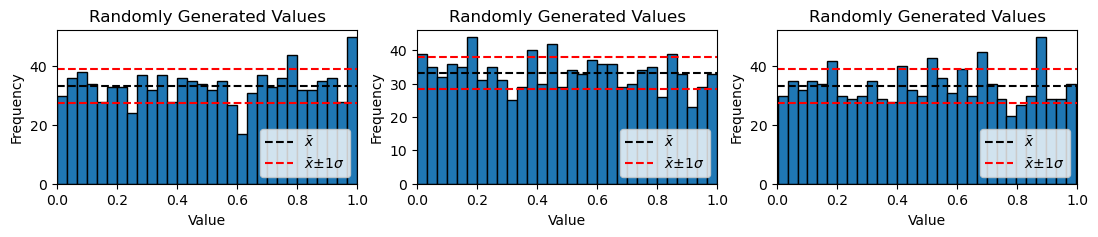

In [ ]:
def plot_hist():
    """
    Plots a histogram of randomly generated arrays. Called by interact

    Parameters:
    num_of_values (tuple): min, max, step, starting_value
                           The number of values in each array.

    Returns:
    None
    """
    # Create figure and axis
    fig, ax = plt.subplots(1, 3, figsize = (12, 2)) # consider 12, 3
    plt.subplots_adjust(left=0.05)
    
    # Loop through each axis
    for i in range(3):
        # Generate random array
        random_array = np.random.uniform(0, 1, 1000)

        # Plot histogram
        ax[i].hist(random_array, bins=30, edgecolor = 'black')
        bins = np.histogram(random_array, bins = 30)
        avg = np.mean(bins[0])
        std_dev = np.std(bins[0])

        # Plot average and standard deviation
        ax[i].hlines(avg, 0, 1, linestyle = '--', color = 'black', label='$\\bar{x}$')
        ax[i].hlines(avg + std_dev, 0, 1, colors='r', linestyles='dashed', label='$\\bar{x} ± 1\\sigma$')
        ax[i].hlines(avg - std_dev, 0, 1, colors='r', linestyles='dashed')

        # Format plot
        ax[i].set_title('Randomly Generated Values')
        ax[i].set_xlabel('Value')
        ax[i].set_ylabel('Frequency')
        ax[i].set_xlim(0, 1)
        ax[i].legend(fontsize = 10, loc = 'lower right')

plot_hist()


The histogram plot above visualises the distribution of the generated random numbers. By plotting the histogram three times, we can see that the random numbers are consistently within the same mean and standard deviation. This consistency indicates that the numbers, while not truly random, maintain a uniform distribution suitable for our simulations.

# Generating random numbers in 3D

Next, we plot the generated random numbers in three dimensions. Through visual inspection of the 3D scatter plot, we can confirm that the points are uniformly distributed, indicating that the random numbers are indeed random and suitable for our simulation purposes.

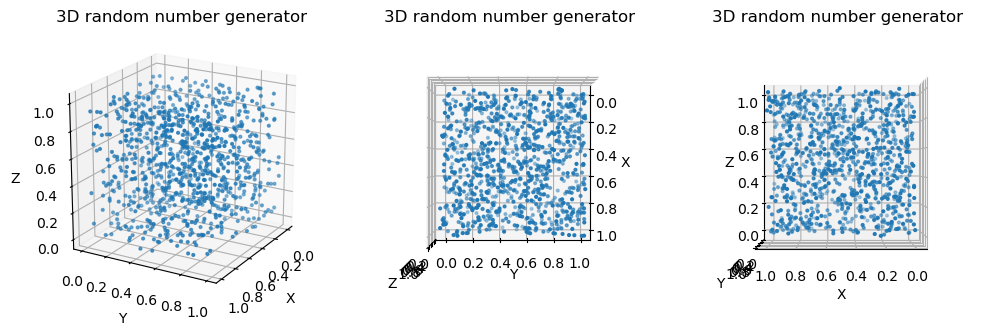

In [ ]:
def plot_3d_random_numbers():
    """
    Plots 3D random numbers using a scatter plot.

    Generates three arrays of random numbers between 0 and 1, and plots them in a 3D space.
    The plot is displayed with three different angles.

    Returns:
    None
    """

    # Generate random numbers
    x = np.random.uniform(0, 1, 1000)
    y = np.random.uniform(0, 1, 1000)
    z = np.random.uniform(0, 1, 1000)

    # Create subplots with 3D projection
    fig, ax = plt.subplots(1, 3, figsize=(12, 6), subplot_kw={'projection':'3d'})

    # Define angles for viewing the plot
    angles = np.array([[20, 90, 0], [30, 0, 90]])

    # Plot the random numbers with different angles
    for i in range(len(angles)+1):
        ax[i].scatter(x, y, z, marker='o', s = 4, depthshade=True)
        ax[i].set_xlabel('X')
        ax[i].set_ylabel('Y')
        ax[i].set_zlabel('Z')
        ax[i].set_title('3D random number generator')
        ax[i].set_box_aspect([1,1,1])
        ax[i].view_init(angles[0][i], angles[1][i])

    # Display the plot
    plt.show()

plot_3d_random_numbers()


## Spectral lines

A linear congruential generator (LCG) produces random numbers using the formula $X_{n+1}=(aX_n + C)$ mod $m$, where $a$, $C$, and $m$ are constants. By normalising the generated numbers through division by $m$, the output is scaled to a uniform distribution over a chosen range. However, the LCG sequence eventually repeats after 
m numbers, and since each number is dependent on the previous one, it is not truly random. `randssp` (Random Sampling with Spectral Preprocessing) is a LCG developed by IBM in the 1960s. `randssp` exhibits issues with hyperplanes, where the sequence may not be uniformly distributed across all dimensions. This issue arises due to the specific preprocessing methods employed, which can inadvertently introduce correlations along hyperplanes, leading to localised biases in the generated random numbers. These localised biases pose challenges for Monte Carlo simulations, as they can introduce unwanted trends and impact the reliability of simulation results. 

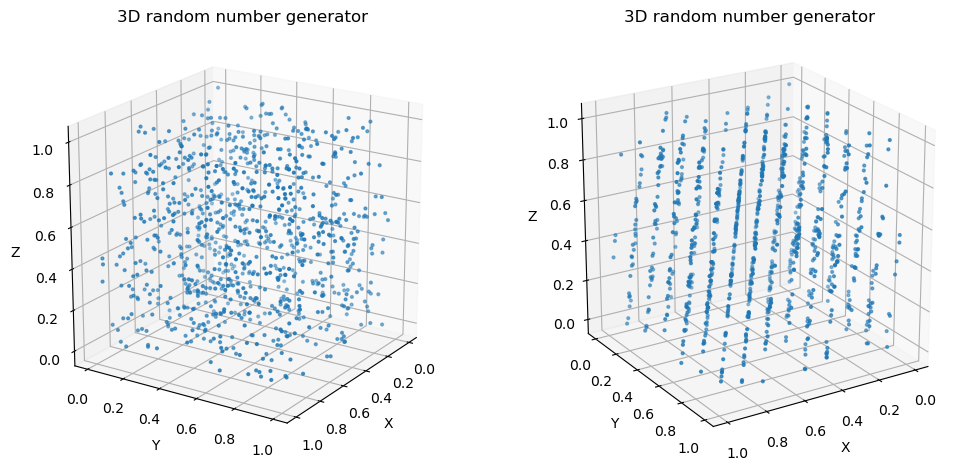

In [ ]:
def randssp(p,q):
    
    global m, a, c, xx
    

    try: xx
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        xx = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            xx = np.mod(a*xx + c, m)
            r[k, l] = xx/m
    
    return r

# Generate random numbers of dimension 3 (x, y, z) and 1000 values
r = randssp(3, 1000)

# Create subplots with 3D projection
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection':'3d'})

# Display the plot at these elevation and azimuth angles. They were specifically chosen to show the 
# hyperplanes appearing as you rotate the plot
angles = np.array([[20, 22], [33, 58]])

# Plot the random numbers with different angles
for i in range(len(angles)):
    ax[i].scatter(r[0], r[1], r[2], marker='o', s = 4, depthshade=True)
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('Y')
    ax[i].set_zlabel('Z')
    ax[i].set_title('3D random number generator')
    ax[i].set_box_aspect([1,1,1])
    ax[i].view_init(angles[0][i], angles[1][i])

The above plot shows that `randssp` at two different angles and rotations. Indeed, it exhibits spectral lines when seen from a specific angle. As such, it cannot be used for Monte-Carlo simulations. `numpy.random.unifrom()` was used instead as it is random enough for the purposes of this project. 

# Simulating neutron transport in water in the absence of scattering

To calculate the attenuation length for water assuming no scattering, only absorption, we utilise the following mathematical principles:

$\textbf{Exponential Distribution Sampling:}$

Samples are distributed according to an exponential function $e^{-\frac{x}{\lambda}}$ where $x$ is the distance travelled in matter, and $\lambda$ is the mean free path, the average distance a neutron can travel before hitting an atom. 

The cumulative distribution function (CDF) is given by 
$$F(x) = 1 - e^{-\frac{x}{\lambda}}.$$
Solving its inverse for a uniform random variable 
$u_i$
in the range of 0 to 1 yields a sample 
$$s_{i}=-\lambda_{T}\ln{u_{i}}$$
$\textbf{Mean Free Path Calculation:}$

The mean free path ($\lambda$) is derived as :
$$\lambda = \frac{1}{\frac{\rho \sigma_{a}N}{M}}$$
where ($\sigma_a$) is the macroscopic absorption cross-section, ($\rho$) is material density, ($N_A$) is Avogadro's number, and the molecular weight is ($M$). 

$\textbf{Beer-Lambert Law:}$

The Beer-Lambert law describes how radiation decreases in matter: 
$$I(d)=I_0 e^{-\frac{d}{\lambda}} $$
where 
$I(d)$ is the intensity at depth $d$. 

To simulate this process we generate random samples $s_i$ using the inverse transform method with $u_i$ generated from a uniform distribution.
Bin the generated samples and perform a weighted linear fit to obtain the attenuation length $\lambda$.
Validate the simulated attenuation length by comparing simulated intensity $I(d)$ with the expected exponential decay behavior according to the Beer-Lambert law.
This approach allows us to estimate the attenuation length of water based solely on absorption processes, providing insights into how radiation interacts with the material.

The following data for water has been given in the project description and is used to calculate hte mean free path. 

| | Water | 
| --- | --- | 
| Absorption, $\sigma_a$ (barn) | 0.6652 | 
| Scattering, $\sigma_s$ (barn) | 103 | 
| Density, $\rho$ $g/cm^3$ | 1.00 |
| Molar Mass, $M$ (g/mol) | 18.0153 |

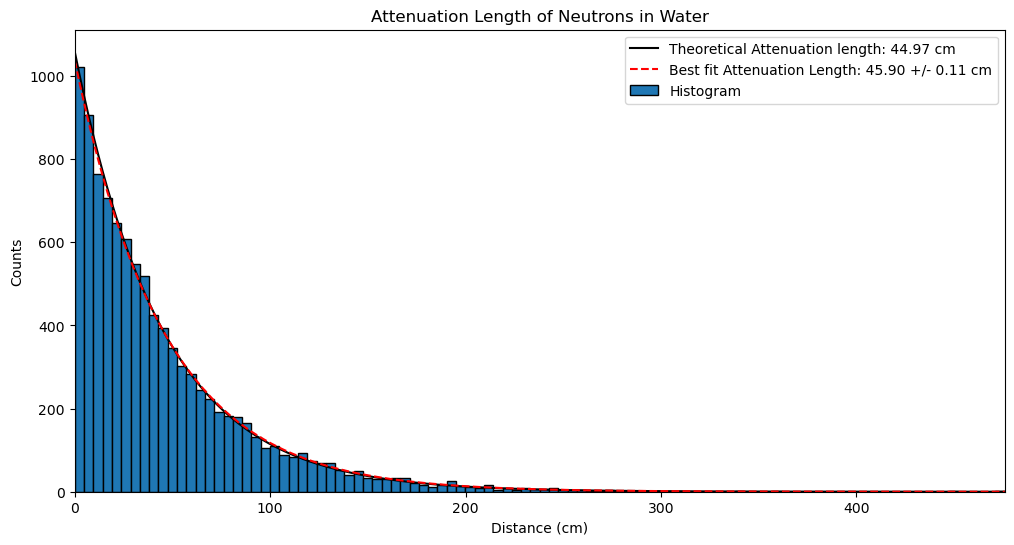

In [ ]:
NREPEAT = 10

def calculate_absorption_mean_free_path(material):
    """
    Calculates the mean free path of particles in a material.

    Parameters:
    density (float): The density of the material in g/cm^3.
    absorption_cross_section (float): The absorption cross section of the material in barn.
    molar_mass (float): The molar mass of the material in g/mol.

    Returns:
    float: The mean free path of particles in the material in meters.
    """
    # Water
    if material == "water":
        density = 1
        absorption_cross_section = 0.6652
        molar_mass = 18.0153
    # Lead
    elif material == "lead":
        density = 11.34
        absorption_cross_section = 0.158
        molar_mass = 207.2
    # Graphite
    elif material == "graphite":
        density = 1.67
        absorption_cross_section = 0.0045
        molar_mass = 12.011
    # Typing error
    else:
        print("Material not found")
        sys.exit()
    # Mean free path for absorption only
    return (1 / (density * absorption_cross_section * constants.Avogadro / molar_mass)) * 10e23

def calculate_random_exponential(mean_free_path, n_random_numbers):
    """
    Calculate random numbers following an exponential distribution.

    Parameters:
    mean_free_path (float): The mean free path of the particles.
    n_random_numbers (int): The number of random numbers to generate.

    Returns:
    numpy.ndarray: An array of length random_numbers following an exponential distribution.
    """
    return - mean_free_path * np.log(np.random.uniform(0, 1, n_random_numbers))


def calculate_attenuation_length(mean_free_path):
    """
    Calculate the attenuation length using the mean free path.

    Parameters:
    - mean_free_path (float): The mean free path value.

    Returns:
    - random_exponential (ndarray): Array of random exponential values.
    - bin_values (ndarray): Array of bin values.
    - bin_middle (ndarray): Array of bin middle values.
    - bin_edges (ndarray): Array of bin edge values.
    - attenuation_length (float): The calculated attenuation length.

    """
    # Initialise variable
    attenuation_length_list = np.zeros(NREPEAT)

    # Repeat NREPEAT times
    for i in range(NREPEAT):
        # Creates random number array
        random_exponential = calculate_random_exponential(mean_free_path, 10000)

        # Calculates histogram
        bin_values, bin_edges = np.histogram(random_exponential, bins = 100)
        bin_middle = np.mean([bin_edges[:-1], bin_edges[1:]], axis=0)

        # Remove zero values
        bin_values_non_zero = bin_values[bin_values > 0]
        bin_middle_non_zero = bin_middle[bin_values > 0]

        # Fit the data
        fit_params = np.polyfit(bin_middle_non_zero, np.log(bin_values_non_zero), 1, w = np.sqrt(
            bin_values_non_zero))
        attenuation_length = - 1 / fit_params[0]

        # Store the attenuation length
        attenuation_length_list[i] = attenuation_length

    attenuation_length = np.mean(attenuation_length_list)
    attenuation_length_std = np.std(attenuation_length_list)/ (np.sqrt(NREPEAT))

    # Plot
    fig = plt.figure(figsize=(12, 6))

    # Plot histogram
    plt.hist(random_exponential, bins=100, edgecolor='black', label = 'Histogram')
    
    # Plot theoretical attenuation curve
    distance = np.linspace(0, bin_edges[-1], 1000)
    counts_theoretical = np.exp(- distance / mean_free_path) / mean_free_path
    counts_theoretical = counts_theoretical * np.sum(bin_values) * (bin_middle[1] - bin_middle[0]) 
    plt.plot(distance, counts_theoretical, color = 'black', 
             label = f"Theoretical Attenuation length: {mean_free_path:.2f} cm")

    # plot best fit attenuation curve
    counts_best_fit = np.exp(- distance / attenuation_length) / attenuation_length
    counts_best_fit = counts_best_fit * np.sum(bin_values) * (bin_middle[1] - bin_middle[0]) 
    plt.plot(distance, counts_best_fit, color='r', linestyle='--', 
             label = f"Best fit Attenuation Length: {attenuation_length:.2f} +/- {attenuation_length_std:.2f} cm")

    # fromat plot
    plt.xlabel('Distance (cm)')
    plt.ylabel('Counts')
    plt.title('Attenuation Length of Neutrons in Water')
    plt.xlim(0, bin_edges[-1])
    plt.ylim(bottom=0)
    plt.legend()



mean_free_path = calculate_absorption_mean_free_path("water")
calculate_attenuation_length(mean_free_path)

The histogram graph above illustrates the exponentially decaying counts of neutrons over distance, depicting the absorption behavior within the material. A theoretical curve has been overlaid on the histogram, showing the expected exponential decay according to the Beer-Lambert law. The alignment between the theoretical curve and the best-fit line to the data suggests that Monte Carlo simulations can accurately capture the absorption processes in the material.

However, the accuracy of the model is heavily limited by the number of samples generated. Increasing the number of samples improves the fidelity of the simulation results, highlighting the importance of adequately sampling the neutron interactions to obtain reliable predictions.

# Generating an Isotropic unit vector

To calculate an isotropic unit vector, we start with spherical coordinates and convert them to Cartesian coordinates. Initially, we use the formulas:
$$x = r \sin(\theta) \cos(\phi)$$
$$y = r \sin(\theta) \sin(\phi)$$
$$ z = r \cos(\theta)$$

where $\theta$ and $\phi$ are randomly generated in the range $0<\theta<\pi$ and $0<\phi<2\pi$. However, this approach results in a non-uniform distribution, with denser point distributions at the poles. To achieve a uniform distribution over the sphere, we correct for this by using:

$$\theta = \arccos(1- 2 u_i)$$

where $u_i$ is a uniformly, randomly distributed variable between 0 and 1. This adjustment ensures that the points are uniformly distributed over the surface of the sphere, providing an isotropic distribution for the unit vectors.

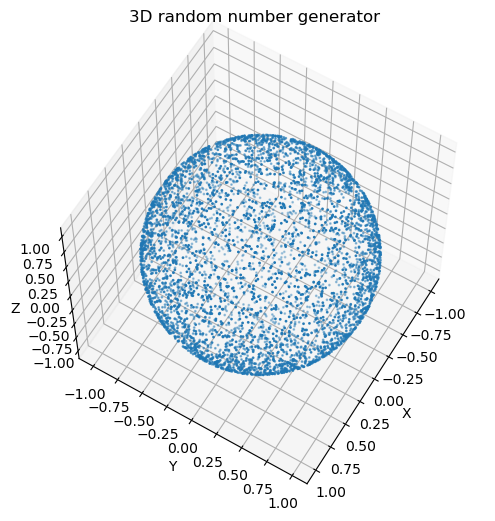

In [ ]:
n_random_numbers = 5000

def calculate_unit_vector(radius, n_random_numbers):
    """
    Calculate the unit vector (of length 1) in three-dimensional space.

    Parameters:
    radius (float): The radius of the sphere.
    n_random_numbers (int): The number of random numbers to generate.

    Returns:
    numpy.ndarray: An array of shape (n_random_numbers, 3) containing the unit vectors.
    """
    # Theta needs to be adjusted using arccos to mitigate the effect of the non-uniform distribution of the 
    # random numbers in theta
    theta = np.arccos(1 - 2 * np.random.uniform(0, 1, n_random_numbers))
    # Phi is uniformly distributed
    phi = 2 * np.pi * np.random.uniform(0, 1, n_random_numbers)

    # Empty unit vector array
    unit_vector = np.zeros((n_random_numbers, 3))

    # Calculate the unit vector
    unit_vector[:, 0] = radius * np.sin(theta) * np.cos(phi)
    unit_vector[:, 1] = radius * np.sin(theta) * np.sin(phi)
    unit_vector[:, 2] = radius * np.cos(theta)
    return unit_vector

def plot_unit_vector(unit_vector):
    """
    Plots a 3D scatter plot of a unit vector.

    Parameters:
    unit_vector (numpy.ndarray): The unit vector to be plotted. Should have shape (N, 3), where N is 
    the number of points.

    Returns:
    None
    """
    # Plot
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the unit vector
    ax.scatter(unit_vector[:,0], unit_vector[:,1], unit_vector[:,2], marker='o', s = 1)
    
    # Format plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D random number generator')
    ax.set_box_aspect([1,1,1])

    # Chose elevation = 60 and azimuth = 30 for best visualization
    ax.view_init(61, 31)

    # Show plot
    plt.show()

unit_vector = calculate_unit_vector(1, n_random_numbers)
plot_unit_vector(unit_vector)

# Isotropic exponential distribution

To obtain an isotropic exponential distribution, we multiply the isotropic unit vector by the random exponential distribution generated earlier. This process involves two steps:

Using the corrected spherical coordinate method, generate unit vectors $\vec{r}$ that are uniformly distributed over the surface of a sphere.

Multiply each unit vector $\vec{r}$ by a random sample $s_i$ drawn from the exponential distribution $e^{-x/\lambda}$.
This results in vectors with directions uniformly distributed in all directions and lengths distributed according to the exponential law. This is used to model the isotropic scattering process of a nucleus. 

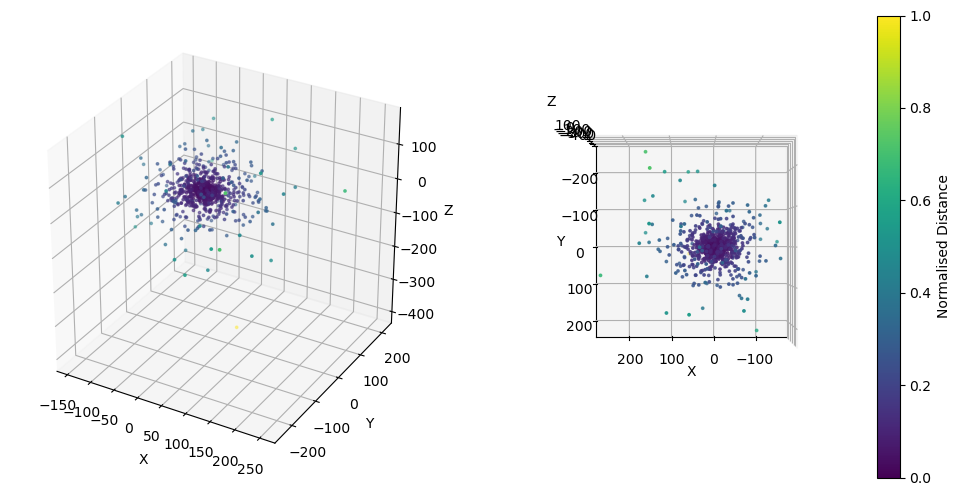

In [ ]:
def isotropic_exp_distr(mean_free_path):
    """
    Plots an isotropic exponential distribution in 3D space.

    This function calculates the mean free path for a given material, generates random exponential values,
    calculates a unit vector, and uses these values to generate points in 3D space. It then calculates the
    distances of these points from the origin, normalizes the distances, and plots the points in a 3D scatter plot.

    Parameters:
    None

    Returns:
    None
    """
    # Calculate an array of random numbers exponentially distributed
    random_exponential = calculate_random_exponential(mean_free_path, 1000)

    # Calculate the unit vector in 3D space
    unit_vector = calculate_unit_vector(1, 1000)

    # Calculate the coordinates by adjusting the length of the unit vector iwth random_exponential as the 
    # step size
    coords = random_exponential[:, np.newaxis] * unit_vector

    return coords


def plot_isotropic_exp_distr(coords):
    """
    Plots the isotropic exponential distribution of given coordinates.

    Parameters:
    coords (numpy.ndarray): Array of coordinates with shape (N, 3), where N is the number of points and 3 
    represents the x, y, and z coordinates.

    Returns:
    None
    """

    # Calculate distances
    distances = np.sqrt(np.sum(np.square(coords), axis=1))
    distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    # Plot the points
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection':'3d'})
    sc = ax[0].scatter(coords[:,0], coords[:,1], coords[:,2], c = distances, marker='o', s = 3)
    sc = ax[1].scatter(coords[:,0], coords[:,1], coords[:,2], c = distances, marker='o', s = 3)
    
    # Format plots
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')
    ax[0].set_zlabel('Z')
    ax[0].set_box_aspect([1,1,1])
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('Y')
    ax[1].set_zlabel('Z')
    ax[1].set_box_aspect([1,1,1])
    ax[1].view_init(90, 90)

    # Show colorbar depending on distances
    plt.colorbar(sc, ax=ax[1], label='Normalised Distance')


mean_free_path = calculate_absorption_mean_free_path("water")
unit_vector = isotropic_exp_distr(mean_free_path)
plot_isotropic_exp_distr(unit_vector)


# Visualising the Neutron Random Walk

The main part of the project involves modeling and visualizing the random walk of neutrons through water, lead, and graphite. The general method for simulating the random walk is as follows:

1) Initialization: Assume the particle is initially at $\vec{r} = (0, 0, 0)$.

2) First Step: Update the position only in the positive $x$-direction according to $\lambda*log(u)$, where u is a random number between 0 and 1. This is to make sure the neutron is within the slab 

3) Generate another random number, $v$, between 0 and 1

4) Check Conditions: 
 - $x > 0$ 
 - $x < L$
 - $v < P_a$ 
 
where $x$ is the x-coordinate of the position of a neutron, $L$, is the slab width, and $P_a$ is the absorption probability. In simpler words, this checks whether the neutron is still within the slab, or whether it has been absorbed. 

5) If it has left the slab or has been absorbed, it is deleted. Otherwise, it is isotropically scattered using the functions we derived above. 

6) Repeat from step 3 until all neutrons have left the slab or have been absorbed. 

However, before we start simulating, we first need to calculate the absorption probability and the mean free path from the given data:

| | Water | Lead | Graphite |
| --- | --- | --- | --- |
| Absorption, $\sigma_a$ (barn) | 0.6652 | 0.158 | 0.0045 |
| Scattering, $\sigma_s$ (barn) | 103 | 11.221 | 4.74 |
| Density, $\rho$ $g/cm^3$ | 1.00 | 11.35 | 1.67 |
| Molar Mass, $M$ (g/mol) | 18.0153 | 207.2 | 12.011 |

For completeness, a vacuum as a material has also been included. For this, the mean free path is automatically set to infinity (approximated as a very large number) and the absorption probabilty is 0. The above data has been transcribed in the `neutron_values()` function. From this we calculate the mean free path as 
$$\lambda = \frac{1}{\frac{\rho \sigma_{a} N}{M}}$$
where the symbols mean the same thing as above. 

The absorption probability is given by 
$$P_a = \frac{\Sigma_a}{\Sigma_a + \Sigma_s}$$
wehere $\Sigma_a$ is the total absorption cross section $\Sigma_a = \sum{n\sigma_a} $ where $n$ is the number density and $\Sigma_s$ is the scattering cross section $\Sigma_s = \sum{n\sigma_s}$. 

In [ ]:
def neutron_values(material):
    """
    Calculate the neutron values for a given material.
    
    Parameters:
    - material (str): The name of the material. Can be one of "water", "lead", "graphite", or "vacuum".
    
    Returns:
    - mean_free_path (float): The mean free path of neutrons in the material, in units of 10^-24 meters.
    - absorption_prob (float): The probability of neutron absorption in the material.
    """
    # Avogadro constant adjusted for barn adn cm^3
    avogadro_constant = constants.Avogadro * 10e-24
    
    # Water
    if material == "water":
        density = 1 # g/cm^3
        absorption_cross_section = 0.6652 # barn
        scattering_cross_section = 103.0 # barn
        molar_mass = 18.0153 # g/mol
    
    # Lead
    elif material == "lead":
        density = 11.34 # g/cm^3
        absorption_cross_section = 0.158 # barn
        scattering_cross_section = 11.221 # barn
        molar_mass = 207.2 # g/mol

    # Graphite
    elif material == "graphite":
        density = 1.67 # g/cm^3
        absorption_cross_section = 0.0045 # barn
        scattering_cross_section = 4.74 # barn
        molar_mass = 12.011 # g/mol
    
    # Vacuum
    elif material == "vacuum":
        # mean_free_path = infinity, but approximated as 10^8, absorption_prob = 0 in vacuum
        return 10e8, 0 
    
    # Typing error
    else:
        print("Material not found")
    
    # Calculate the macroscopic cross sections
    macro_absorption_cross_section = (density * absorption_cross_section  / molar_mass * avogadro_constant)

    # Scattering cross section
    scattering_cross_section_macro = (density * scattering_cross_section / molar_mass * avogadro_constant)

    # Total cross section
    total_cross_section = macro_absorption_cross_section + scattering_cross_section_macro

    # Calculate the absorption probability
    absorption_prob = macro_absorption_cross_section / total_cross_section

    # Calculate the mean free path
    mean_free_path = 1 / total_cross_section

    # Adjust mean free path to cm, absorption probabilty is fine
    return mean_free_path*10, absorption_prob

Now we need to simulate the neutrons in the `simulate_neutrons`function. The process described above is executed as follows:

1) Calculate the mean free path and the absorption probability with `neutron_values`

2) `initialise_neutrons` sets the initial position to $\vec{r} = (0, 0, 0)$ and ensures the first step is in the positive x-direction direction $(1, 0, 0)$.

3) If `paths = True`, create an empty array `history`which records all past and present positions of all neutrons. This is only used for plotting purposes and not in later simualtions.

4) Start a while loop that runs as long as there are still neutrons in the simulation.

5) The `calculate_steps` function calculates a step in a random direction. It also takes care of the edge case when a step is very large (such as in a vacuum) and reduces this. 

6) Update the current position by adding a step length distributed by the random exponential distribution in the random direction given by `calculate_steps`. For the first iteration, this is in the direction $(1, 0, 0)$. 

7) If `paths = True`, we append the new position here so that it can be plotted. For later simulations, this is set to False to save computation time. 

8) `calculate_masks` outputs the indices of the neutrons which have been absorbed, backscattered, or transmitted. They are removed. 

9) We count the number of neutrons absorbed, backscattered, and transmitted and repeat from step 4 until no neutrons are left in the simulation.

10) Finally, `plot_neutron_transport` calls `simulate_neutrons` and plots the neutron paths stored in `history` for all materials. 

In [ ]:
def calculate_steps(nneutrons, mean_free_path):
    """
    Calculates the steps taken by neutrons in a medium accodingto the exponential distribution.

    Parameters:
    - nneutrons (int): The number of neutrons currently in the simulation.
    - mean_free_path (float): The mean free path of the neutrons.

    Returns:
    - steps (ndarray): An array containing the steps taken by each neutron.

    """
    # Calculate the step lengths according to the exponential distribution
    steps = calculate_random_exponential(mean_free_path, nneutrons)

    # Limit step size to slab thickness for vacuum
    steps = np.where(steps > 10, 10 + 2, steps)

    return steps


def initialise_simulation(nneutrons):
    """
    Initializes the simulation by creating arrays for the current positions and directions of neutrons.

    Parameters:
    nneutrons (int): The number of neutrons in the simulation.

    Returns:
    current_position (numpy.ndarray): An array of shape (nneutrons, 3) representing the initial positions of 
    the neutrons.
    current_direction (numpy.ndarray): An array of shape (nneutrons, 3) representing the initial directions of 
    the neutrons.
    """
    # Initial position is (0, 0, 0)
    current_position = np.zeros((nneutrons, 3))

    # First step is in the x-direction. Every step following is calculated using the unit vector and isotropically 
    # in every direction with equal probability
    current_direction = np.tile([1, 0, 0], (nneutrons, 1))

    return current_position, current_direction


def calculate_masks(nneutrons, current_position, absorbtion_probability, slab_thickness):
    """
    Calculate masks for different neutron states based on their positions and absorption probability.

    Parameters:
    - nneutrons (int): Number of neutrons.
    - current_position (numpy.ndarray): Array of shape (nneutrons, 3) representing the current positions of 
    neutrons.
    - absorbtion_probability (float): Probability of neutron absorption.
    - slab_thickness (float): Thickness of the slab.

    Returns:
    - backscattered_mask (numpy.ndarray): Boolean mask indicating whether neutrons are backscattered.
    - transmitted_mask (numpy.ndarray): Boolean mask indicating whether neutrons are transmitted.
    - outside_slab_mask (numpy.ndarray): Boolean mask indicating whether neutrons are outside the slab.
    - absorbed_mask (numpy.ndarray): Boolean mask indicating whether neutrons are absorbed.
    - scattered_mask (numpy.ndarray): Boolean mask indicating whether neutrons are scattered.
    """
    # Calculate mask for backscattered neutrons
    backscattered_mask = current_position[:, 0] < 0

    # Calculate mask for transmitted neutrons
    transmitted_mask = current_position[:, 0] > slab_thickness

    # Calculate mask for neutrons outside the slab (backscattered and transmitted)
    outside_slab_mask = backscattered_mask + transmitted_mask

    # Calculate mask for absorbed neutrons according to a random number < absorption probability
    absorbed_mask = np.random.uniform(size = nneutrons) < absorbtion_probability

    # Calculate mask for scattered neutrons (neutrons that don't get deleted)
    scattered_mask = np.logical_and(~outside_slab_mask, ~absorbed_mask)

    return backscattered_mask, transmitted_mask, outside_slab_mask, absorbed_mask, scattered_mask


def simulate_neutrons(nneutrons, material, paths, slab_thickness):
    """
    Simulates the behavior of neutrons in a given material.

    Parameters:
    - nneutrons (int): The number of neutrons to simulate.
    - material (str): The material in which the neutrons are simulated.
    - paths (bool): Whether to store the neutron paths.
    - slab_thickness (float): The thickness of the slab in which the neutrons are simulated.

    Returns:
    - nreflected (int): The number of neutrons that are reflected.
    - ntransmitted (int): The number of neutrons that are transmitted.
    - nabsorbed (int): The number of neutrons that are absorbed.
    - history (list): A list of lists containing the positions of the neutrons at each step, if `paths` is True.
    """
    # Calculate the mean free path and absorption probability
    mean_free_path, absorbtion_probability = neutron_values(material)

    # Initialise Counts
    nabsorbed = 0
    nreflected = 0
    ntransmitted = 0
    num = 0

    # Initialise simulation
    current_position, current_direction = initialise_simulation(nneutrons)

    # Append initial positions to history if paths = True
    # Initialise history keeping track of neutron positions to be plotted. Not needed if pahts = False
    history = [[] for _ in range(nneutrons)]
    remaining_indices = np.arange(nneutrons)
        
    # Apppend (0, 0, 0) too to make sure vacuum neutrons are plotted
    for neutron_index in range(nneutrons):
        history[neutron_index].append(current_position[neutron_index])

    # Loop until all neutrons are absorbed, backscattered, or transmitted
    while nneutrons > 0:
        
        # Do not run for first loop because the initial direction of the first step is already set in the 
        # x-direction
        if num > 0:
            current_direction = calculate_unit_vector(1, nneutrons)
        
        # Calculate the step size
        steps = calculate_steps(nneutrons, mean_free_path)

        # Update the current position
        current_position = current_position + steps[:,np.newaxis] * current_direction

        # Append positions to history if paths = True
        if paths:
            for neutron_index, neutron_number in enumerate(remaining_indices):
                history[neutron_number].append(current_position[neutron_index])
        
        # Calculate masks for different neutron states
        backscattered_mask, transmitted_mask, outside_slab_mask, absorbed_mask, scattered_mask = calculate_masks(
            nneutrons, current_position, absorbtion_probability, slab_thickness)
        
        # Remove neutrons not scattered
        current_position = current_position[scattered_mask]

        if paths:
            # Update the array keeping track of which neutrons have been deleted
            remaining_indices = remaining_indices[scattered_mask]

        # Count the number of neutrons in each state
        nreflected += np.sum(backscattered_mask)
        ntransmitted += np.sum(transmitted_mask)
        nabsorbed += np.sum(absorbed_mask & ~outside_slab_mask)

        # Count remaining neutrons
        nneutrons = np.sum(~absorbed_mask & ~outside_slab_mask)

        # Increment the number of loops
        num += 1
    
    return nreflected, ntransmitted, nabsorbed, history


The simulation above will be used thorughout the project. `Plot_neutron_transport` below simulates 9 neutrons and plots them for each material.

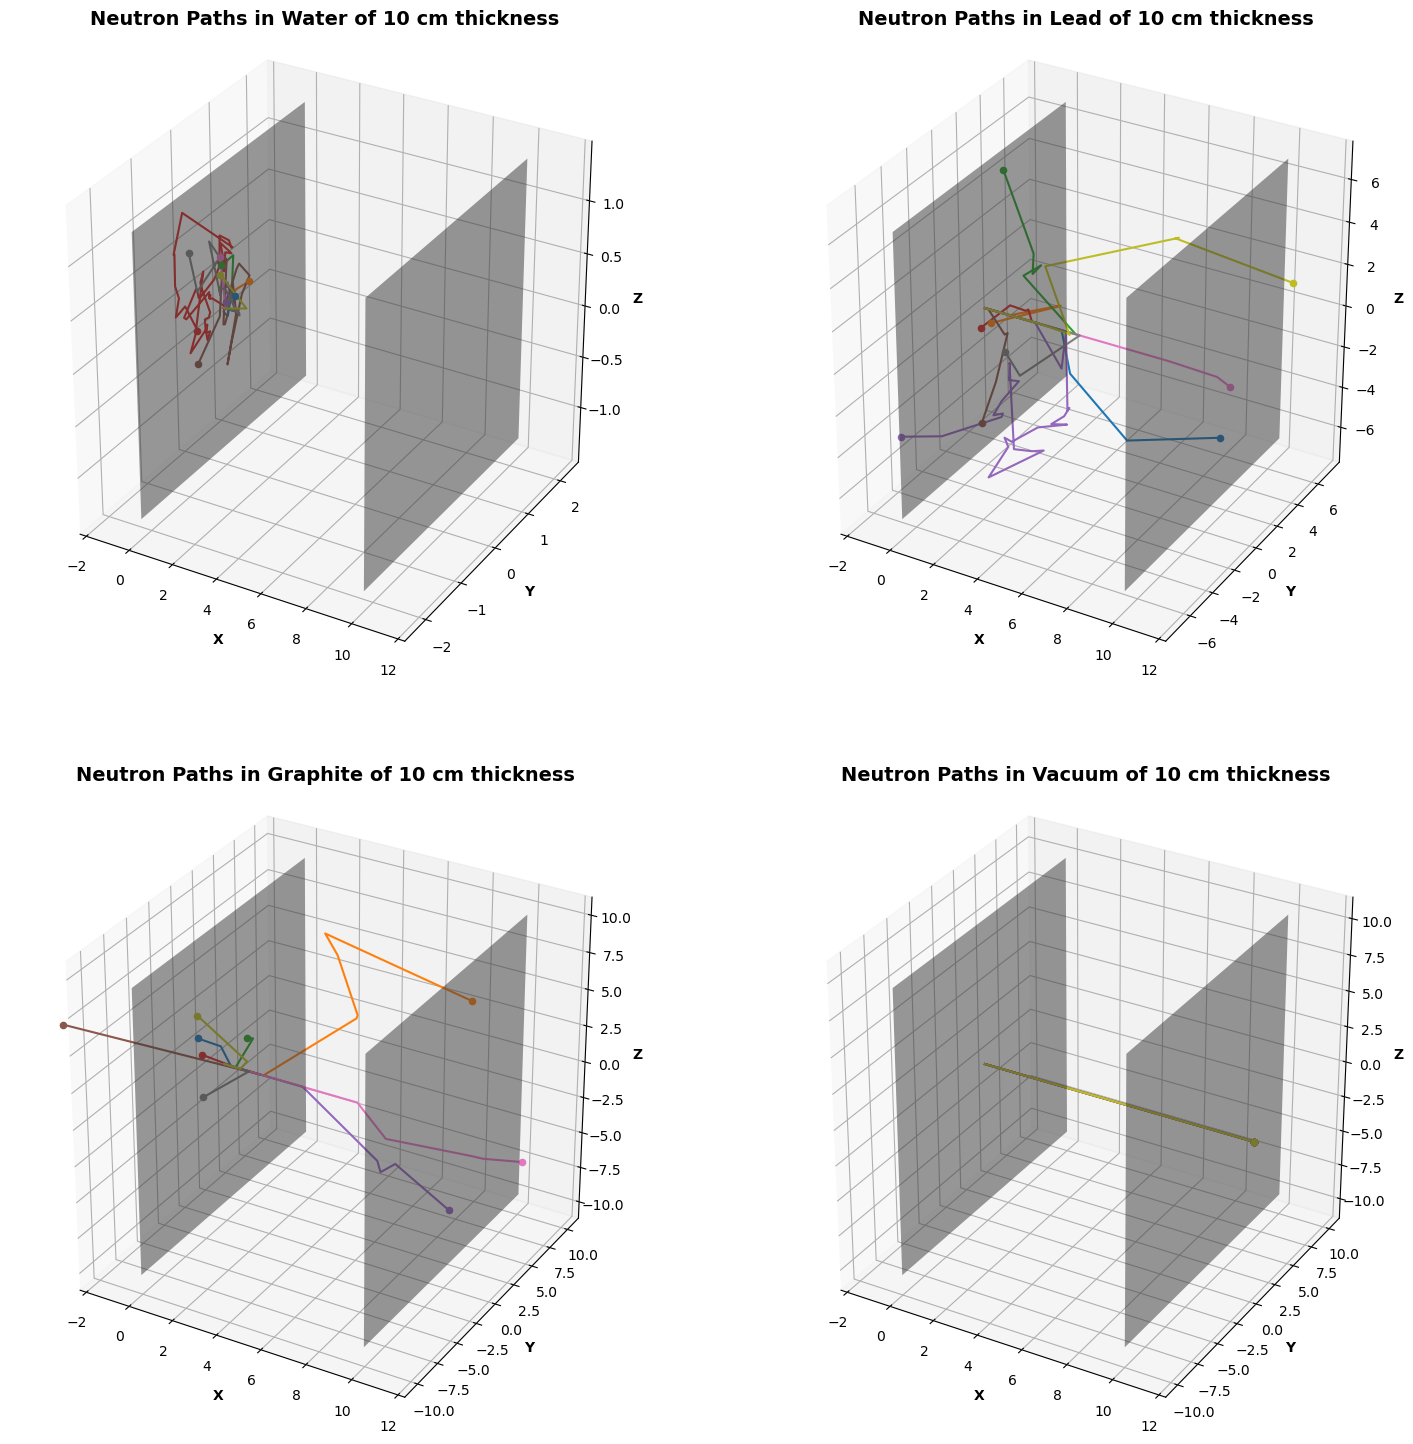

In [ ]:

def plot_neutron_transport(nneutrons, material_list):
    """
    Plots the paths of neutrons in different materials.

    Parameters:
    - nneutrons (int): The number of neutrons to simulate.
    - material_list (list): A list of materials to simulate the neutrons in.

    Returns:
    None
    """
    # Create figure
    fig = plt.figure(figsize=(18, 18))

    # Set slab thickness to 10 for all materials for now
    slab_thickness = 10

    # Loop over all materials
    for plot_index, material in enumerate(material_list):
        
        # Create subplot
        ax = fig.add_subplot(2, 2, plot_index + 1, projection='3d')
        
        # Simulate neutrons
        _, _, _, history = simulate_neutrons(nneutrons, material, True, slab_thickness)
        
        # Initialise lists to store x, y, and z values, as well as the max values of y and z
        x_val = []
        y_val = []
        z_val = []
        y_max = []
        z_max = []

        # Loop over all neutrons and plot their paths
        for i in history:
            # Loop over all steps of the neutron
            for j in i:
                # Append x, y, and z values to the lists
                x_val.append(j[0])
                y_val.append(j[1])
                z_val.append(j[2])
            
            # Find max values of y and z, used to find the limits of the plot and slab
            y_max.append(np.max(np.abs(y_val)))
            z_max.append(np.max(np.abs(z_val)))

            # Plot each neutron path
            ax.plot(x_val, y_val, z_val)
            ax.scatter(x_val[-1], y_val[-1], z_val[-1])

            # Reset the lists
            x_val = []
            y_val = []
            z_val = []

        # Edge case where max value is 0 for vacuum
        if np.max(y_max) == 0 or np.max(z_max) == 0:
            y_max = z_max = [10]

        # Plot the slab
        yy, zz = np.meshgrid([-np.max(y_max), np.max(y_max)], [-np.max(z_max), np.max(z_max)])
        ax.plot_surface(np.zeros_like(yy), yy, zz, alpha = 0.5, color = 'gray')
        ax.plot_surface(np.full_like(yy, slab_thickness), yy, zz, alpha = 0.5, color = "gray")

        # Format plot
        ax.set_xlabel("X", fontweight = 'bold')
        ax.set_ylabel("Y", fontweight = 'bold')
        ax.set_zlabel("Z", fontweight = 'bold')
        ax.set_box_aspect([1,1,1])
        plt.xlim(-2, slab_thickness + 2)
        ax.set_title(f"Neutron Paths in {material.capitalize()} of {slab_thickness} cm thickness", fontweight = 'bold', fontsize = 14)

# Number of neutrons
nneutrons = 9
# List of materials
material_list = ["water", "lead", "graphite", "vacuum"]

plot_neutron_transport(nneutrons, material_list)

The above shows the simulated neutron paths in water, lead, graphite, and in a vacuum

$\textbf{Water}$

The neutron paths in water show significant scattering, with many neutrons taking random paths before being absorbed or escaping the slab. The high scattering cross-section of water leads to numerous interactions, resulting in a complex path distribution.

$\textbf{Lead}$

Lead has a lower scattering cross-section resulting in longer and less convoluted paths. The high density of lead significantly contributes to its absorption capability, as the dense atomic structure increases the likelihood of interactions. 

$\textbf{Graphite}$

Graphite, with its lower absorption and scattering cross-sections shows longer neutron paths with fewer interactions compared to water and lead. Neutrons travel further distances before being absorbed, leading to a more uniform distribution of paths across the slab. 

$\textbf{Vacuum}$

In a vacuum, neutrons travel in straight lines without any interactions, as there is no absorption or scattering. This results in direct paths through the slab without any deviation. The mean free path is infinite, and the absorption probability is zero, illustrating the absence of material interactions and testing my simulation for edge cases. 

# Quantifying scattering processes

We simulate 10000 neutrons 10 times to find statistically significant trends in their scatterting, absorption, and transmission behaviour. 

In [ ]:
paths = False
nneutrons = 10000
iterations = 10

# Empty array of dimensions (number of materials, 3, number of iterations)
results = np.zeros((len(material_list), 3, iterations))

# Loop over materials
for material_index, material in enumerate(material_list):
    # Loop over iterations
    for i in range(iterations):
        # Simulate neutrons and append to results
        results[material_index, 0, i], results[material_index, 1, i], results[material_index, 2, i], _ = simulate_neutrons(
            nneutrons, material, paths, 10)

# convert to percentage
results = results / nneutrons * 100

def tabulate_results(results, material_list):
    """
    Tabulates the results of a simulation and displays them in a formatted DataFrame.

    Parameters:
    - results (numpy.ndarray): A 2D array containing the simulation results.
    - material_list (list): A list of material names corresponding to the simulation results.

    Returns:
    None
    """

    # Create a DataFrame from the results
    df = pd.DataFrame({
        'Material': material_list,
        'Reflected': np.mean(results[:, 0], axis=1),
        'Transmitted': np.mean(results[:, 1], axis=1),
        'Absorbed': np.mean(results[:, 2], axis=1),
        'Reflected Error': np.std(results[:, 0], axis=1),
        'Transmitted Error': np.std(results[:, 1], axis=1),
        'Absorbed Error': np.std(results[:, 2], axis=1)
    })

    # Capitalize the material names
    df['Material'] = df['Material'].str.capitalize()

    # Combine mean results and errors into a single cell with the format "mean ± error"
    df['Reflected'] = df['Reflected'].map('{:.2f}'.format) + ' ± ' + df['Reflected Error'].map('{:.2f}'.format)
    df['Transmitted'] = df['Transmitted'].map('{:.2f}'.format) + ' ± ' + df['Transmitted Error'].map('{:.2f}'.format)
    df['Absorbed'] = df['Absorbed'].map('{:.2f}'.format) + ' ± ' + df['Absorbed Error'].map('{:.2f}'.format)

    # Drop the error columns
    df = df.drop(columns=['Reflected Error', 'Transmitted Error', 'Absorbed Error'])

    # Set the Material column as the index
    df.set_index('Material', inplace=True)

    # Add '%' to the column names
    df.columns = [f'{col} (%)' for col in df.columns]

    # Transpose the DataFrame
    #df = df.transpose()

    # Display the DataFrame
    display(df)

tabulate_results(results, material_list)


,Reflected (%),Transmitted (%),Absorbed (%)
Material,,,
Water,79.78 ± 0.30,0.34 ± 0.05,19.88 ± 0.29
Lead,61.92 ± 0.49,28.17 ± 0.47,9.92 ± 0.38
Graphite,68.42 ± 0.29,30.78 ± 0.27,0.81 ± 0.07
Vacuum,0.00 ± 0.00,100.00 ± 0.00,0.00 ± 0.00


We have simulated 10,000 neutrons in 10 separate simulations for each material: water, lead, graphite, and vacuum. This high number of simulations ensures that the trends observed are statistically significant. The results for the percentage of neutrons reflected, transmitted, and absorbed are summarised in the table above.

Water exhibits a high reflection rate and a substantial absorption rate, with very few neutrons being transmitted. This is consistent with water's high scattering and absorption cross-section. The frequent collisions lead to significant reflection and absorption, making water an effective neutron moderator and absorber. 

Lead shows a more balanced interaction profile, with a significant percentage of neutrons being transmitted and a relatively high reflection rate. The absorption rate is lower compared to water, which aligns with lead's lower scattering cross-section but higher density. This allows many neutrons to penetrate through lead while still reflecting and absorbing a considerable portion due to its high atomic number. 

Graphite has the highest transmission rate among the materials (excluding vacuum) and the lowest absorption rate. This is due to graphite's low absorption cross-section and low scattering properties. The density of graphite is higher than water but much lower than lead, facilitating the transmission of neutrons through the material while reflecting a significant portion due to its crystalline structure.

As expected, in a vacuum, there are no interactions with neutrons, leading to 100% transmission and no reflection or absorption. This serves as a control to demonstrate the behavior of neutrons in the absence of any material interactions.

Due to its high absorption efficacy, water can serve as a very good shielding material. However, as it is not always practical to use, lead is a good substitute. Graphtie, due to its high transmission and low absorption rates is can serve as a moderator in nuclear fission reactors. 

# Plotting variations in neutron behaviour for different lengths of material

In this section, we will explore the impact of varying the thickness of the slab on the transmission, absorption, and reflection rates of thermal neutrons. We will conduct the simulation by varying the thickness of the slab 20 times and observing the corresponding ratios of transmitted, absorbed, and reflected neutrons. Each data point will be obtained by repeating the simulation 10 times with 10,000 neutrons for statistical significance. To determine the attenuation length of each material, we will fit the mean transmission rate data to the Beer–Lambert law equation
$$ N = N_0 e^{-x/\lambda}$$ 
where $x$ represents distance through the slab, $N_0$ the intial number of neutrons, and $N$ the absorbed number of neutrons. By linearising and doing a weighted fit, we can obtain the attenuation length $\lambda$ of each material. The attenuation length quantifies the distance over which the intensity of radiation decreases to $1/e$ (approximately 36.8%) of its initial value. The greater the attenuation length, the less effective is the material at attenuating neutrons. 

We first call the `simulate_neutrons` function in `get_results` to obtain an array `results` which stores the total number of neutrons reflected, transmitted, and absorbed. We perform a fit using the `do_fit` function by fitting the thickness variation $\log(T_{mean})$ to a linear curve with each data point weighted as $T_{mean}/T_{std}$ where $T_{mean}$ and $T_{std}$ are the mean and standard deviation of the transmission rate. 

The `run_simulations` function brings everything together, calling `get_results`, `do_fit`, `plot_material_neutron_transport` while iterating over all materials.

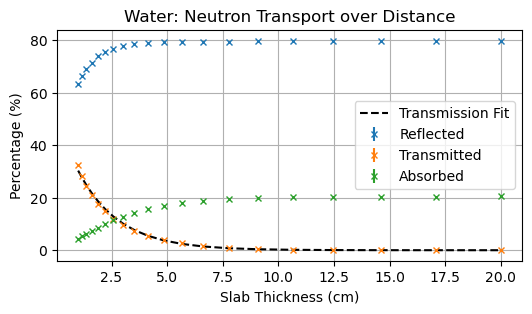

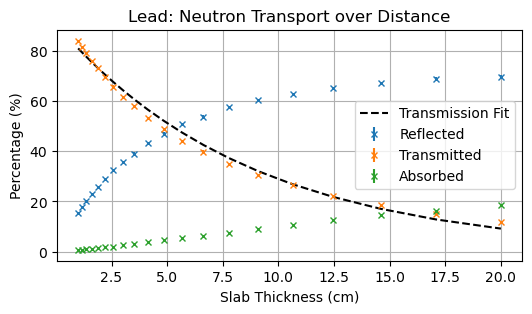

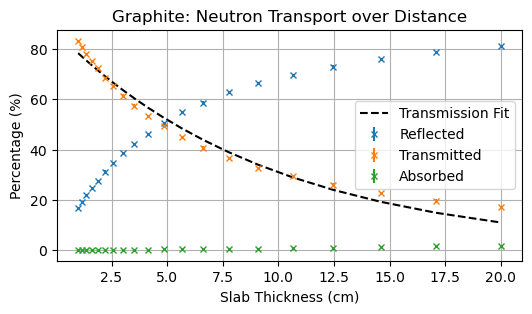

In [ ]:
slab_thickness = np.geomspace(1, 20, 20)
material_list = ["water", "lead", "graphite"]
iterations = 10
nneutrons = 10000
paths = False


def get_results(nneutrons, material, paths, slab_thickness):
    """
    Calculate and return the results of neutron simulation for different materials and slab thicknesses.

    Parameters:
    - nneutrons (int): The number of neutrons to simulate.
    - material (str): The material to simulate the neutrons in.
    - paths (list): List of paths for the neutrons.
    - slab_thickness (list): List of thicknesses for the slabs.

    Returns:
    - results (ndarray): Array containing the simulation results for each material, thickness, and iteration.
    """
    # Empty array of dimensions (number of materials, number of thicknesses, 3, number of iterations)
    results = np.zeros((len(slab_thickness), 3, iterations))

    # Loop over materials

        # Loop over slab thicknesses
    for thickness_index, thickness in enumerate(slab_thickness):

        # Loop over iterations
        for i in range(iterations):

            # Simulate neutrons and append to results
            results[thickness_index, 0, i], results[thickness_index, 1, i], results[thickness_index, 2, i], _ = simulate_neutrons(
                nneutrons, material, False, thickness)

    return results

def do_fit(slab_thickness, results, error):
    """
    Fits the transmission data to an exponential curve to calculate the attenuation length.

    Args:
        slab_thickness (array-like): Array-like object containing slab thickness values.
        log_results (array-like): Array-like object containing the log of the results.
        log_errors (array-like): Array-like object containing the log of the errors.

    Returns:
        array: 1D array containing the attenuation length
        Array: 1D array of the attenuation length uncertainty for each material.
    """
    log_results = np.log(results[:,1])

    log_errors = error[:,1] / results[:,1]

    weight = 1 / log_errors
    fit_params, cov = np.polyfit(slab_thickness, log_results, 1, w = weight, cov = True)

    return fit_params, cov


def plot_material_neutron_transport(results, error, fit_params, slab_thickness, material):
    """
    Plots the neutron transport data for a given material.

    Parameters:
    - results (ndarray): Array containing the neutron transport results.
    - error (ndarray): Array containing the errors in the neutron transport results.
    - fit_params (ndarray): Array containing the fit parameters for the transmission fit.
    - slab_thickness (ndarray): Array containing the slab thickness values.
    - material (str): Name of the material.

    Returns:
    - None

    """
    # Initialise plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    # PLot the reflected, transmitted, and absorbed percentage values against slab thickness
    ax.errorbar(slab_thickness, results[:,0], yerr = error[:,0], fmt= 'x', label = 'Reflected', markersize = '4')
    ax.errorbar(slab_thickness, results[:,1], yerr = error[:,1], fmt = 'x', label = 'Transmitted', markersize = '4')
    ax.errorbar(slab_thickness, results[:,2], yerr = error[:,2], fmt = 'x', label = 'Absorbed', markersize = '4')

    # Plot the fit
    ax.plot(slab_thickness, np.exp(fit_params[1]) * np.exp(fit_params[0] * slab_thickness), 
            color = 'black', linestyle = '--', label = 'Transmission Fit')

    # Format plot
    ax.set_title(f'{material.capitalize()}: Neutron Transport over Distance')
    ax.legend()
    ax.set_xlabel('Slab Thickness (cm)')
    ax.set_ylabel('Percentage (%)')
    ax.grid(True)


def run_simulations(nneutrons, material_list, paths, slab_thickness, iterations):
    """
    Calculates the error and formats the results of neutron transport simulation.
    Plots the results of neutron transport simulation. 
    Fits the transmission data to an exponential curve to calculate the attenuation length. 


    Args:
        nneutrons (int): Number of neutrons.
        material_list (list): List of materials.
        paths (list): List of file paths.
        slab_thickness (array-like): Array-like object containing slab thickness values.
        iterations (int): Number of iterations.

    Returns:
        array: 1D array containing the attenuation length
        Array: 1D array of the attenuation length uncertainty for each material.

    """
    # Define empty arrays for attenuation length and its uncertainty to be filled for each material
    attenuation_length = np.zeros((len(material_list)))
    attenuation_length_uncertainty = np.zeros((len(material_list))) 

    # Get results
    for i, material in enumerate(material_list):
        results = get_results(nneutrons, material, paths, slab_thickness)

        # Calculate mean and standard deviation
        error = np.std(results, axis=2)
        results = np.mean(results, axis=2)
   
        # Convert to percentage
        results /= 100
        error = error / 100

        # Remove zero values
        results = np.array([col for col in results.T if not np.any(col == 0)]).T
        error = np.array([col for col in error.T if not np.any(col == 0)]).T
    
        # Fit the data
        fit_params, cov = do_fit(slab_thickness, results, error)

        # Plot the results
        plot_material_neutron_transport(results, error, fit_params, slab_thickness, material)

        # Calculate the attenuation length and its uncertainty
        attenuation_length[i] = -1 / fit_params[0]
        attenuation_length_uncertainty[i] = np.sqrt(np.diag(cov))[0] * attenuation_length[i] **2

    return attenuation_length, attenuation_length_uncertainty


attenuation_length, attenuation_length_uncertainty = run_simulations(nneutrons, material_list, paths, 
                                                                     slab_thickness, iterations)


In [ ]:
def gen_table(material_list, attenuation_length, attenuation_length_uncertainty):
    """
    Generate a DataFrame table with material names, attenuation lengths, and their uncertainties.

    Parameters:
    - material_list (list): A list of material names.
    - attenuation_length (list): A list of attenuation lengths.
    - attenuation_length_uncertainty (list): A list of uncertainties for the attenuation lengths.

    Returns:
    - df (pandas.DataFrame): The generated DataFrame table with the following columns:
        - Material: The capitalized material names.
        - Attenuation Length: The attenuation lengths formatted as "{length:.2f} ± {uncertainty:.2f}".
    """

    # Create a DataFrame
    df = pd.DataFrame({
        'Material': [material.capitalize() for material in material_list],
        'Attenuation Length': [f"{length:.2f} ± {uncertainty:.2f}" for length, uncertainty in zip(
            attenuation_length, attenuation_length_uncertainty)],
    })
    df.set_index('Material', inplace=True)

    # Return the DataFrame
    return df

gen_table(material_list, attenuation_length, attenuation_length_uncertainty)

,Attenuation Length
Material,
Water,1.84 ± 0.04
Lead,8.74 ± 0.23
Graphite,9.70 ± 0.50


The significance of these attenuation lengths lies in their implications for radiation shielding and attenuation effectiveness. Materials with shorter attenuation lengths, such as water, are more efficient at attenuating radiation over shorter distances, making them suitable for applications where compact shielding is required. Conversely, materials with longer attenuation lengths, like lead and graphite, are effective at attenuating radiation over longer distances, making them suitable for applications where thicker shielding is feasible.

These results align with the properties observed in the neutron simulation, where water exhibited higher absorption and scattering rates compared to lead and graphite. The lower attenuation length of water indicates its higher effectiveness in attenuating radiation over shorter distances due to its high absorption cross section and higher interaction probabilities with neutrons.

In conclusion, the attenuation lengths derived from the Monte Carlo simulation provide valuable insights into the shielding properties of different materials and their suitability for various radiation attenuation applications. These findings contribute to the optimisation of radiation shielding designs and the selection of appropriate materials for specific radiation attenuation requirements in nuclear engineering, medical diagnostics, and other radiation-sensitive applications.

In [ ]:
# End timer
end_time = time.time()

# Print execution time
print(f"Execution time: {end_time - start_time:.2f} seconds")

Execution time: 38.59 seconds


The code's runtime of approximately 40 seconds falls within the required 45-second limit and significantly exceeds expectations compared to a runtime of over one minute.

# Woodcock method

### EGS Sampling

The Electron Gamma Sampling (EGS) method is a stochastic approach to simulate the path of neutrons through a material. It involves sampling the distances a neutron travels before undergoing scattering or absorption, based on the respective probability distributions.

### The Woodcock Method

The Woodcock method simplifies the tracking process by introducing a fictitious uniform medium with a constant total cross-section, $\Sigma_T$, which is the highest total cross-section among all materials in the problem.

The Woodcock method works as follows:

1) Determine the total mean free path for both layers using $\lambda_T = 1/\max{\Sigma_1, \Sigma_2}$ where $\Sigma_1$ and $\Sigma_2$ are the macroscopic cross sections of the first and second layer respectively. 

2) As the first step, move the neutron along the x-direction using an exponentially distributed step length based on $\lambda_T$

3) Determine whether the particle is inside or outside the bi-layer slab. If the particle is outside, update the reflection and transmission counts accordingly.

4) Interaction handling: Inside the Layer with the smaller cross section $\Sigma_{min}$
  - Generate a random number $v$
  - Check if $ v > \Sigma_{min}/\Sigma_{max}$
  - If true, treat the step as fictitious (do not update the position or counts), and move the neutron in the same direction using a new exponential step length.
  - If false, treat the step as a normal step and determine if the particle is absorbed or scattered using the same method as for a single-layer barrier.
    
5) Interaction handling: Inside the layer with the bigger cross section $\Sigma_{max}$
  - Treat the step as a normal step and determine if the particle is absorbed or scattered using the same method as for a single-layer barrier.
    
6) Repeat from 3) until all neutrons have been absorbed or are outside both slabs


The Woodcock method efficiently handles neutron transport in heterogeneous materials by simplifying the path length sampling process. It uses a fictitious medium with a constant total cross-section to streamline the determination of interactions, which are then validated or rejected based on the actual material properties. This method ensures accurate simulation of neutron transport while optimizing computational resources.

In [ ]:
def calculate_mask_woodcock(nneutrons, current_position, materials, material_thicknesses, 
                            absorption_probabilities):
    """
    Calculates various masks based on the current neutron positions and material properties.

    Parameters:
    - nneutrons (int): The number of neutrons.
    - current_position (numpy.ndarray): The current positions of the neutrons.
    - materials (list): The list of materials.
    - material_thicknesses (list): The list of material thicknesses.
    - absorption_probabilities (list): The list of absorption probabilities.

    Returns:
    - backscattered_mask (numpy.ndarray): A mask indicating whether the neutrons are backscattered.
    - transmitted_mask (numpy.ndarray): A mask indicating whether the neutrons are transmitted.
    - outside_slab_mask (numpy.ndarray): A mask indicating whether the neutrons are outside the slab.
    - absorbed_mask (numpy.ndarray): A mask indicating whether the neutrons are absorbed.
    - scattered_mask (numpy.ndarray): A mask indicating whether the neutrons are scattered.
    """
    # Calculate masks for backscattered, transmitted, outside slab, absorbed, and scattered neutrons
    backscattered_mask = current_position[:, 0] < material_thicknesses[0]

    # Calculate transmitted mask based on the last material thickness
    transmitted_mask = current_position[:, 0] > material_thicknesses[-1]

    # Calculate outside slab mask
    outside_slab_mask = backscattered_mask + transmitted_mask

    # Calculate absorption probability index based on the current position
    absorption_probability_index = np.where(current_position[:,0] < material_thicknesses[1], 
                                            absorption_probabilities[0], absorption_probabilities[1])

    # Calculate absorbed mask based on the absorption probability
    absorbed_mask = np.random.uniform(size = nneutrons) < absorption_probability_index

    # Calculate scattered mask
    scattered_mask = np.logical_and(~outside_slab_mask, ~absorbed_mask)

    return backscattered_mask, transmitted_mask, outside_slab_mask, absorbed_mask, scattered_mask


def calculate_direction_woodcock(nneutrons, current_position, material_thicknesses, 
                                 total_cross_section, current_direction):
    """
    Calculates the direction of neutrons using the Woodcock method.

    Parameters:
    - nneutrons (int): The number of neutrons.
    - current_position (numpy.ndarray): The current position of the neutrons.
    - material_thicknesses (list): The thicknesses of the materials.
    - total_cross_section (list): The total cross sections of the materials.
    - current_direction (numpy.ndarray): The current direction of the neutrons.

    Returns:
    - numpy.ndarray: The updated direction of the neutrons.
    """
    # Calculate the index of all neutrons in the first material
    neutrons_in_1_index = current_position[:,0] < material_thicknesses[1]

    # Calculate the probability of a fictitious step
    fictitious_probability = 1 - (np.where(neutrons_in_1_index, total_cross_section[0], 
                                           total_cross_section[1])/max(total_cross_section[0], 
                                                                       total_cross_section[1]))

    # Generate random numbers to determine whether the neutron is going to do a fictitious step
    fictitous_indices = np.random.uniform(0, 1, len(fictitious_probability)) < fictitious_probability
    real_indices = ~fictitous_indices

    # Calculate the unit vector isotropically (as before)
    unit_vector = calculate_unit_vector(1, nneutrons)
    
    # Calculate the new direction for real neutrons, but keep the old direction for fictitious neutrons
    current_direction[real_indices] = unit_vector[real_indices]

    return current_direction


def woodcock_method(nneutrons, materials, material_thicknesses, paths):
    """
    Simulates the Woodcock tracking method for a given number of neutrons.

    Parameters:
    - nneutrons (int): The number of neutrons to simulate.
    - materials (list): A list of materials.
    - material_thicknesses (list): A list of thicknesses corresponding to each material.
    - paths (bool): Flag indicating whether to store the neutron positions in history.

    Returns:
    - nreflected (int): The number of neutrons that were backscattered.
    - ntransmitted (int): The number of neutrons that were transmitted.
    - nabsorbed (int): The number of neutrons that were absorbed.
    - history (list): A list of lists containing the positions of each neutron at each step.
    """
    # Calculate the mean free paths and absorption probabilities for each material, append them to a list
    mean_free_paths = np.zeros((len(materials)))
    absorption_probabilities = np.zeros((len(materials)))

    for material_index, material in enumerate(materials):
        mean_free_paths[material_index], absorption_probabilities[material_index] = neutron_values(material)
    
    # Calculate the total cross section and mean free path
    total_cross_section = 1/mean_free_paths
    total_mean_free_path = 1/max(total_cross_section)

    # Initialise the current position of the neutrons
    current_position = np.zeros((nneutrons, 3))

    # First step is in the x-direction. Every step following is calculated using the unit vector and 
    # isotropically in every direction with equal probability
    current_direction = np.tile([1, 0, 0], (nneutrons, 1)).astype(float)

    # Append initial positions to history if paths = True
    history = [[] for _ in range(nneutrons)]
    remaining_indices = np.arange(nneutrons)

    # Initialise counts
    nabsorbed = 0
    nreflected = 0
    ntransmitted = 0
    num = 0

    # Loop until all neutrons are absorbed, backscattered, or transmitted
    while nneutrons > 0:
        
        # Do not run for first loop because the initial direction of the first step is already set in the 
        # x-direction
        if num > 0:
            current_direction = calculate_direction_woodcock(nneutrons, current_position, material_thicknesses, 
                                                             total_cross_section, current_direction)

        # Calculate the step size (for fictitious and real steps)
        step_size = calculate_steps(nneutrons, total_mean_free_path)

        # Update the current position
        current_position = current_position + step_size[:,np.newaxis] * current_direction

        # Append positions to history if paths = True
        if paths:
            for neutron_index, neutron_number in enumerate(remaining_indices):
                history[neutron_number].append(current_position[neutron_index])

        # Calculate masks for different neutron states
        backscattered_mask, transmitted_mask, outside_slab_mask, absorbed_mask, scattered_mask = calculate_mask_woodcock(
            nneutrons, current_position, np.nan, material_thicknesses, absorption_probabilities)

        # Remove neutrons not scattered, ignore fictitious neutrons
        current_position = current_position[scattered_mask]
        current_direction = current_direction[scattered_mask]

        # paths = True
        if paths:
            # Update the array keeping track of which neutrons have been deleted
            remaining_indices = remaining_indices[scattered_mask]

        # Count the number of neutrons in each state
        nreflected += np.sum(backscattered_mask)
        ntransmitted += np.sum(transmitted_mask)
        nabsorbed += np.sum(absorbed_mask)

        # Count remaining neutrons
        nneutrons = np.sum(~absorbed_mask & ~outside_slab_mask)

        # Increment the number of loops
        num += 1

    return nreflected, ntransmitted, nabsorbed, history


def run_woodcock_simulations(nneutrons, materials, material_thicknesses, iterations, paths):
    """
    Run Woodcock simulations to calculate the percentages and uncertainties of neutron interactions.

    Parameters:
    - nneutrons (int): The number of neutrons to simulate.
    - materials (list): A list of materials used in the simulations.
    - material_thicknesses (list): A list of thicknesses corresponding to each material.
    - iterations (int): The number of iterations to perform.
    - paths (list): A list of paths for the simulations.

    Returns:
    - percentages (ndarray): An array of percentages representing the average neutron interactions for each 
      material.
    - uncertainties (ndarray): An array of uncertainties representing the standard deviation of neutron 
      interactions for each material.
    """
    # Calculate the number of materials
    n_materials = len(materials)
    
    # Empty array to store results
    results = np.zeros((3 * n_materials, iterations))

    # Loop over iterations
    for i in range(iterations):
        
        # Loop over materials
        for j in range(n_materials):

            # Simulate neutrons and append to results
            results[3*j, i], results[3*j+1, i], results[3*j+2, i], _ = woodcock_method(nneutrons, 
                                                                                       materials[j], 
                                                                                       material_thicknesses[j], 
                                                                                       paths)

    # Calculate the percentages and uncertainties
    percentages = np.mean(results, axis=1) / nneutrons * 100
    uncertainties = np.std(results, axis=1) / nneutrons * 100

    return percentages, uncertainties


def tabulate_woodcock(materials, material_thicknesses, percentages, uncertainties):
    """
    Tabulates the Woodcock data for different materials and their thicknesses.

    Args:
        materials (list): A list of tuples representing the materials used in the experiment.
                          Each tuple contains two strings representing the names of the two materials.
        material_thicknesses (list): A list of tuples representing the thicknesses of the materials.
                                     Each tuple contains three floats representing the thicknesses
                                     of the first material, the second material, and the total thickness.
        percentages (list): A list of floats representing the percentages of reflected, transmitted,
                            and absorbed radiation for each material.
        uncertainties (list): A list of floats representing the uncertainties associated with the
                              percentages of reflected, transmitted, and absorbed radiation for each material.

    Returns:
        HTML: An HTML object containing the tabulated data.

    """
    # Create a dictionary to store the data
    data = {
        "Thickness 1 (cm)": [],
        "Material 1": [],
        "Thickness 2 (cm)": [],
        "Material 2": [],
        "Reflected (%)": [],
        "Transmitted (%)": [],
        "Absorbed (%)": []
    }

    # Loop over materials and append data to the dictionary
    for i in range(len(materials)):
        data["Thickness 1 (cm)"].append(material_thicknesses[i][1] - material_thicknesses[i][0])
        data["Material 1"].append(materials[i][0].capitalize())
        data["Thickness 2 (cm)"].append(material_thicknesses[i][2] - material_thicknesses[i][1])
        data["Material 2"].append(materials[i][1].capitalize())
        data["Reflected (%)"].append(f"{percentages[3*i]:.2f} ± {uncertainties[3*i]:.2f}")
        data["Transmitted (%)"].append(f"{percentages[3*i+1]:.2f} ± {uncertainties[3*i+1]:.2f}")
        data["Absorbed (%)"].append(f"{percentages[3*i+2]:.2f} ± {uncertainties[3*i+2]:.2f}")

    # Create a DataFrame from the data
    df = pd.DataFrame(data)

    # Convert the DataFrame to an HTML object so it can be displayed properly
    df_html = df.to_html(index=False)

    return HTML(df_html)


# Number of neutrons
nneutrons = 10000

# List of materials and thicknesses, each array in materials represents a pair of materials
materials = [["lead", "lead"], ["water", "water"]]

# List in material_thicknesses represents the boundaries of material array in materials. For example, 
# [0, 5, 10] means that the first material is from 0 to 5 cm, 
# and the second material is from 5 to 10 cm. The last boundary is the total thickness of the slab.
# Must start at 0 to the left, but any other boundary can be chosen at will. 
# The last boundary will be the total thickness of the slab. Assumes non-overlapping materials and non-negative 
# thicknesses.
material_thicknesses = [[0, 5, 10], [0, 5, 10]]
iterations = 10

# Do not record history. Only need the percentages and uncertainties
paths = False

percentages, uncertainties = run_woodcock_simulations(nneutrons, materials, material_thicknesses, iterations, paths)  
tabulate_woodcock(materials, material_thicknesses, percentages, uncertainties, )


Thickness 1 (cm),Material 1,Thickness 2 (cm),Material 2,Reflected (%),Transmitted (%),Absorbed (%)
5,Lead,5,Lead,61.74 ± 0.36,28.32 ± 0.36,11.20 ± 0.26
5,Water,5,Water,79.67 ± 0.17,0.30 ± 0.04,20.51 ± 0.19


We ran the Woodcock simulation 10 times with 10,000 neutrons. The results in the table above show that combining two identical slabs of the same material, each 5 cm thick, produces very similar outcomes to those obtained using a single 10 cm slab. This consistency implies that the Woodcock method is accurate for quantifying scattering processes.

Given this accuracy, we can now experiment with various combinations of materials and slab thicknesses. The parameters in the simulation can be adjusted to explore different material configurations, allowing for a wide range of simulations to better understand how different materials interact in shielding scenarios.

In [ ]:
nneutrons = 10000
# List of materials and thicknesses, each array in materials represents a pair of materials
materials = [["lead", "water"], ["water", "graphite"]]
# List of material_thicknesses
material_thicknesses = [[0, 2, 10], [0, 3, 10]]
iterations = 10
paths = False

percentages, uncertainties = run_woodcock_simulations(nneutrons, materials, material_thicknesses, iterations, paths)
tabulate_woodcock(materials, material_thicknesses, percentages, uncertainties)

Thickness 1 (cm),Material 1,Thickness 2 (cm),Material 2,Reflected (%),Transmitted (%),Absorbed (%)
2,Lead,8,Water,59.39 ± 0.68,0.63 ± 0.08,40.79 ± 0.65
3,Water,7,Graphite,78.69 ± 0.31,6.19 ± 0.20,15.59 ± 0.29


We can see that with water and lead, the absorption is as expected slightly higher than either and the transmission rate falls extremely low. Similarly, the reflection increases for graphite and water, in comparison to only graphite. 

Now, we adjust the slab thicknesses to be 10 cm each and run the simulation again for different combinations of materials. 

In [ ]:
nneutrons = 10000
# List of mateirals and thicknesses, each array in materials represents a pair of materials
materials = [["lead", "graphite"], ["water", "lead"]]
material_thicknesses = [[0, 10, 20], [0, 10, 20]]
iterations = 10
paths = False

percentages, uncertainties = run_woodcock_simulations(nneutrons, materials, material_thicknesses, iterations, paths)
tabulate_woodcock(materials, material_thicknesses, percentages, uncertainties)

Thickness 1 (cm),Material 1,Thickness 2 (cm),Material 2,Reflected (%),Transmitted (%),Absorbed (%)
10,Lead,10,Graphite,70.90 ± 0.51,13.92 ± 0.27,16.16 ± 0.51
10,Water,10,Lead,79.65 ± 0.53,0.03 ± 0.02,20.83 ± 0.52


We can also visually assess these combinations of materials.

In [ ]:
def plot_woodcock(ax, materials, material_thicknesses, history, plot_number):
    """
    Plots the neutron paths in a 3D plot. Adpated from plot_neutron_transport for the Woodcock method but not significantly different

    Parameters:
    - ax (matplotlib.axes.Axes): The axes to plot on.
    - materials (list): A list of two strings representing the materials.
    - material_thicknesses (list): A list of three floats representing the thicknesses of the materials.
    - history (list): A list of lists containing the neutron path coordinates.
    - plot_number (int): The number of the plot.

    Returns:
    None
    """

    # Initialise lists to store x, y, and z values, as well as the max values of y and z
    x_val = []
    y_val = []
    z_val = []
    y_max = []
    z_max = []

    # Loop over all neutrons
    for i in history:

        # Loop over all steps of the neutron
        for j in i:

            # Append x, y, and z values to the lists
            x_val.append(j[0])
            y_val.append(j[1])
            z_val.append(j[2])
        
        # Find max values of y and z, used to find the limits of the plot and slab
        y_max.append(np.max(np.abs(y_val)))
        z_max.append(np.max(np.abs(z_val)))

        # Plot each neutron path
        ax.plot(x_val, y_val, z_val)
        ax.scatter(x_val[-1], y_val[-1], z_val[-1])

        # Reset the lists
        x_val = []
        y_val = []
        z_val = []

    # Create meshgrid for the slab
    yy, zz = np.meshgrid([-np.max(y_max), np.max(y_max)], [-np.max(z_max), np.max(z_max)])

    # Plot the slab
    ax.plot_surface(np.zeros_like(yy), yy, zz, alpha = 0.5, color = 'gray')
    ax.plot_surface(np.full_like(yy, material_thicknesses[1]), yy, zz, alpha = 0.5, color = "lightblue")
    ax.plot_surface(np.full_like(yy, material_thicknesses[2]), yy, zz, alpha = 0.5, color = "ghostwhite")

    # Format plot
    ax.set_xlabel("X", fontweight = 'bold')
    ax.set_ylabel("Y", fontweight = 'bold')
    ax.set_zlabel("Z", fontweight = 'bold')
    ax.set_box_aspect([1,1,1])

    ax.view_init(elev=10, azim=-80)

    # Set the title of the plot
    ax.set_title(f"{plot_number+1}: Neutron Paths in {materials[0].capitalize()} of {material_thicknesses[1]-material_thicknesses[0]} cm thickness and {materials[1].capitalize()} of {material_thicknesses[2]-material_thicknesses[1]} cm thickness", fontsize = 12, y=0.95)

We call the `plot_woodcock` function for the same materials and slab thickness values that we used above. 

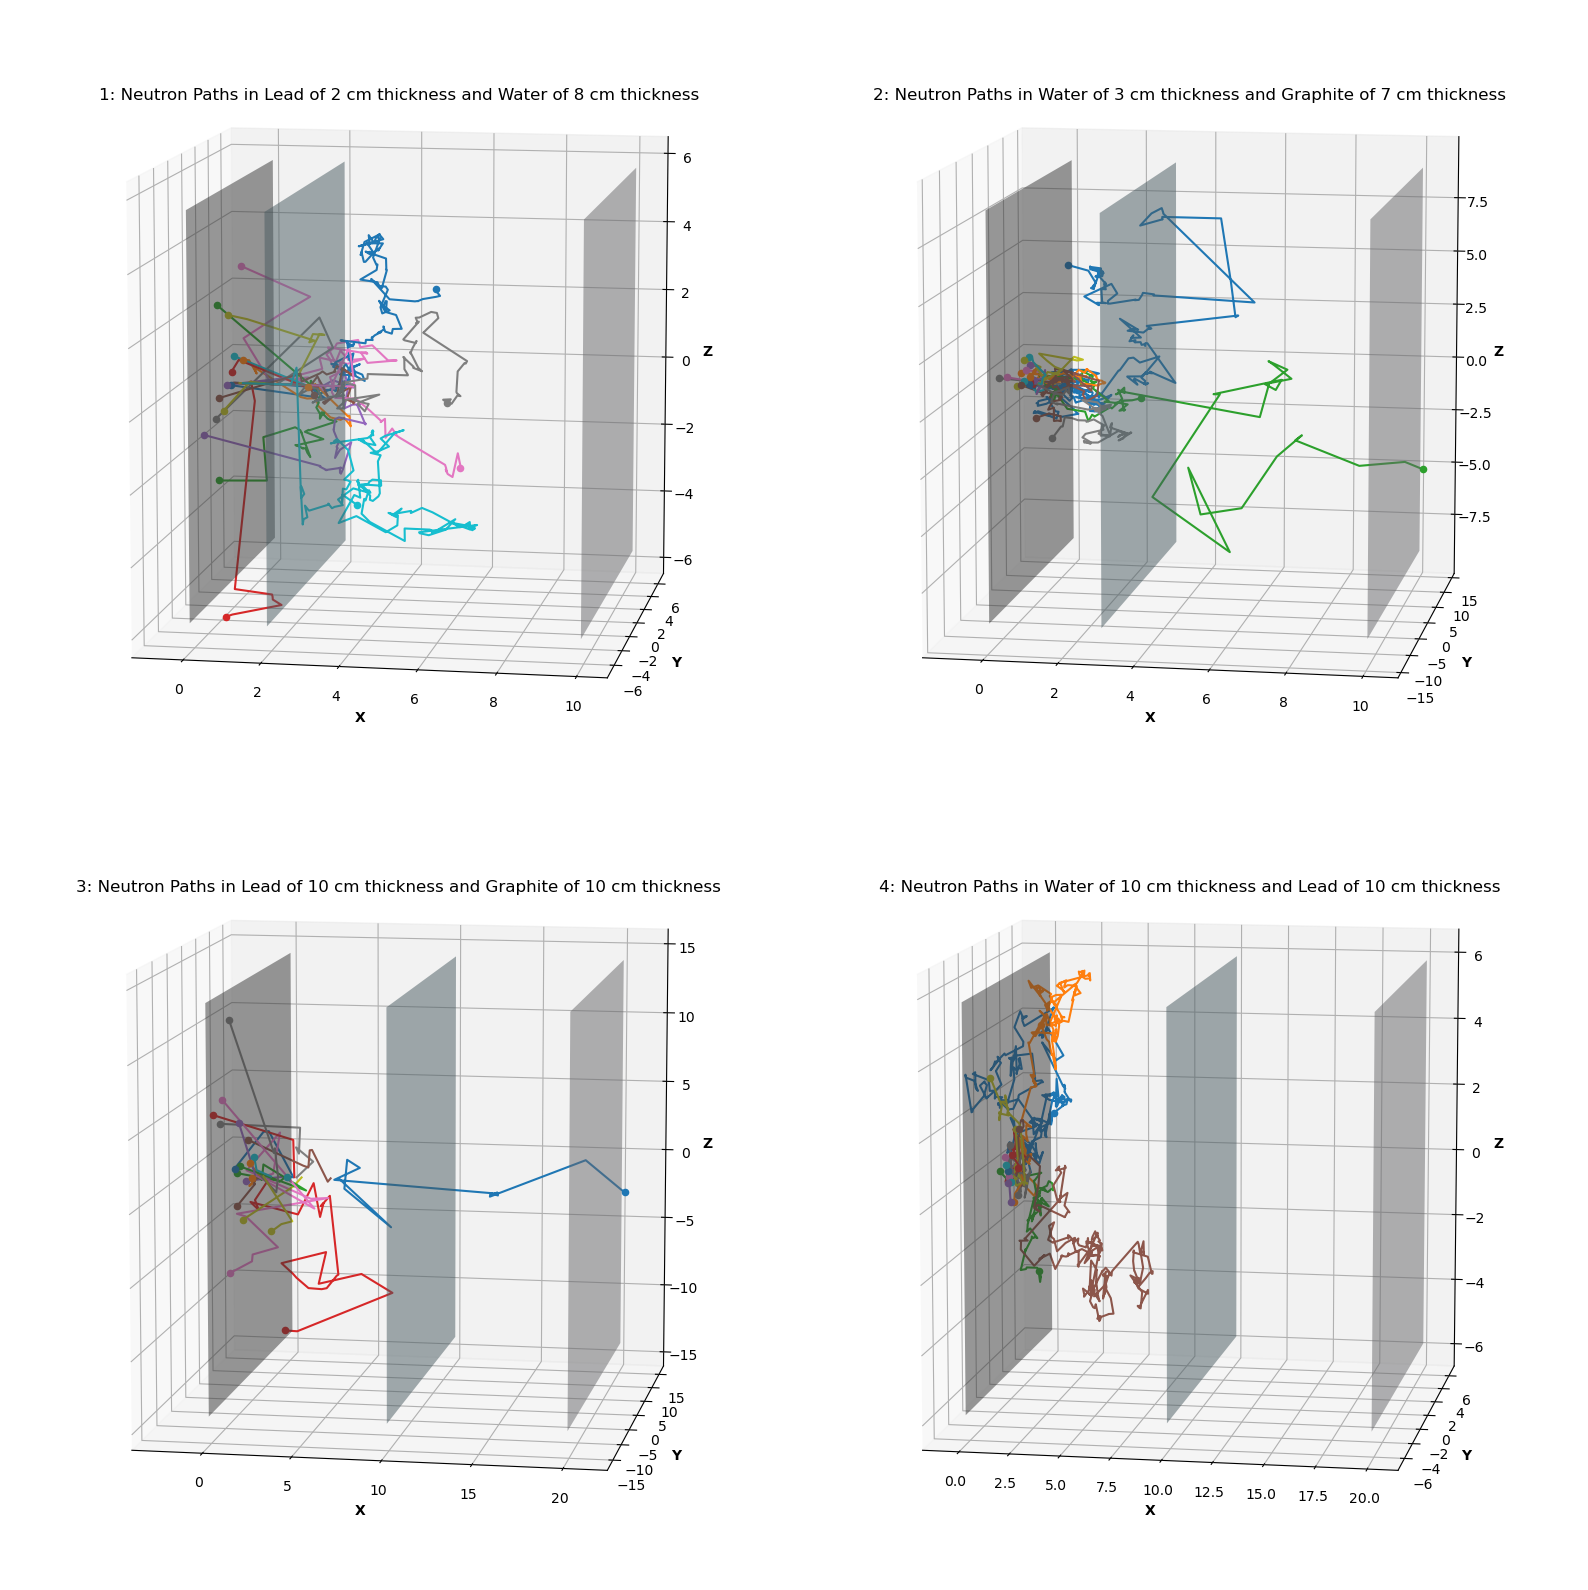

In [ ]:
# List in material_thicknesses represents the boundaries of material array in materials. For example, [0, 5, 10] 
# means that the first material ranges from 0 to 5 cm, 
# and the second material is from 5 to 10 cm. 
# Must start at 0 to the left, but any other boundary can be chosen at will. 
# The last boundary will be the total thickness of the slab. Assumes non-overlapping materials and non-negative 
# thicknesses.
material_thicknesses = [[0, 2, 10], [0, 3, 10], [0, 10, 20], [0, 10, 20]]
materials = [["lead", "water"], ["water", "graphite"], ["lead", "graphite"], ["water", "lead"]]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 16), subplot_kw={'projection': '3d'})

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate through the lists above and plot each
for plot_number, (ax, thicknesses, mats) in enumerate(zip(axs, material_thicknesses, materials)):
    _, _, _, history = woodcock_method(20, mats, thicknesses, True)
    plot_woodcock(ax, mats, thicknesses, history, plot_number)

# Adjust the layout
plt.tight_layout()
plt.show()

$\textbf{Graphs 1 and 2:}$ Using the Woodcock method, we explored variations in neutron behavior when simulating double slabs composed of different materials, specifically water followed by lead, then graphite followed by water. The results above show notable differences in neutron interactions based on the order of the materials. In the lead-water configuration, neutrons experienced significant absorption in the lead layer before reaching the water layer, resulting in fewer neutrons interacting with water. This led to higher overall absorption and lower transmission rates. Conversely, in the water-graphite configuration, neutrons underwent extensive scattering in the water layer before reaching the lead. This configuration resulted in higher reflection rates and lower transmission. These observations give a visual aid in understanding the transmission, absorption, and reflection rates we calculated in the table above.

$\textbf{Graphs 4 and 4:}$ Two more graphs are plotted for the other combinations of materials. 

For the lead (10 cm) followed by graphite (10 cm) configuration, the results indicated that neutrons were significantly absorbed in the lead layer before reaching the graphite, leading to reduced interaction within the graphite and lower overall transmission rates. The graphite layer, having a lower absorption cross-section, allowed scattered neutrons to travel further, demonstrating higher reflection compared to the single-material slabs.

In the water (10 cm) followed by lead (10 cm) configuration, neutrons experienced substantial scattering in the water layer before reaching the lead (if at all), which increased the probability of absorption in the lead layer making its value extremely low.

# Conclusion

In this project, we developed a computational simulation to study the absorption and scattering processes of thermal neutrons through various shielding materials using Monte Carlo techniques. The materials investigated included water, lead, and graphite.

We began by generating uniformly distributed random numbers using numpy.random.uniform() and visualised these in three dimensions to ensure proper distribution. Functions were then created to produce isotropic unit vectors and isotropic steps with lengths distributed exponentially, essential for modeling neutron paths in three-dimensional space.

Next, we visualised the random walk of neutrons through slabs of different materials, considering absorption, scattering, and transmission conditions. By simulating multiple neutrons passing through slabs of fixed thickness, we determined the reflection, absorption, and transmission rates for each material. Using the Beer-Lambert law the  attenuation lengths for each material were determined. 

The Woodcock method was also implemented to handle neutron transport in heterogeneous materials, confirming its accuracy and efficiency.

The results showed that water had the highest scattering and absorption rates, making it an effective neutron moderator and absorber. Lead exhibited balanced interaction profiles with significant absorption, while graphite allowed the highest transmission rates. Water's short attenuation length indicated high effectiveness in radiation attenuation over short distances, while lead and graphite, with longer attenuation lengths, are suited for thicker shielding applications. The Woodcock method proved accurate for simulating neutron transport through combined material layers.

Ulimately, this project highlighted the ability for Monte Carlo simulations to accurately model real life scenarios related to neutron transport and shielding in matter, improving our understanding and building the foundation for future studies. 